# April 25, 2024: Calcium + fMRI data; correlation matrices

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob
from itertools import combinations

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
CAL_data_path = f'{BASE_path}/data/Calcium/SLC/REST'
fMRI_data_path = f'{BASE_path}/data/fMRI/SLC/REST'

ROI_RESULTS_path = f'{BASE_path}/roi_results'
CAL_path = f'{ROI_RESULTS_path}/calcium'
fMRI_path = f'{ROI_RESULTS_path}/fmri'
os.system(f'mkdir -p {CAL_path}')
os.system(f'mkdir -p {fMRI_path}')

0

In [4]:
args.unit = 'seswise'

In [5]:
CAL_PARCELS = f'{BASE_path}/data/2D_calcium_atlas.nii.gz'
fMRI_PARCELS = f'{BASE_path}/data/N162_merge_medium_fine_224_0.2_RAS.nii.gz'

CAL_PARCELS, fMRI_PARCELS

('/home/govindas/new_mouse_dataset/data/2D_calcium_atlas.nii.gz',
 '/home/govindas/new_mouse_dataset/data/N162_merge_medium_fine_224_0.2_RAS.nii.gz')

calcium data 

In [6]:
# roi time series
bands = ['FastBand', 'SlowBand']
for band in bands:
    files = sorted(glob.glob(f'{CAL_data_path}/session-*/{band}/*', recursive=True))
    os.system(f'mkdir -p {CAL_path}/{band}/roi_timeseries')
    with open(f'{CAL_path}/{band}/all_nii_files.txt', 'w') as f:
        f.writelines('\n'.join(files))
    
    if len(sorted(glob.glob(f'{CAL_path}/*/roi_timeseries/*', recursive=True))) == 0:
        os.system((
            f'bash 00ab-data-ca_desc-run-roi-timeseries.sh '
            f'{CAL_path}/{band}/all_nii_files.txt '
            f'{CAL_PARCELS}'
        ))

In [7]:
def create_dataframe(files):
    def get_basr(fs):
        # band, animal, session, run
        band = fs[-3]
        asr = fs[-1].split('_')[:3]
        return [band] + asr
    
    def get_ts(file):
        ts = np.loadtxt(file)
        ts = stats.zscore(ts, axis=0, nan_policy='omit')
        ts = np.nan_to_num(ts)
        return ts        

    dataset_df = []

    for file in tqdm(files):
        fs = file.split('/')
        band, aml, ses, run = get_basr(fs)
        ts = get_ts(file)
        
        df = pd.DataFrame({
            'band':[band],
            'aml':[aml],
            'ses':[ses],
            'run':[run],
            'ts':[ts],
        })
        dataset_df.append(df)
        
    dataset_df = pd.concat(dataset_df).reset_index(drop=True)
    return dataset_df

In [8]:
dataset_df = create_dataframe(
    files=sorted(glob.glob(
        f'{CAL_path}/*/roi_timeseries/*', 
        recursive=True))
)

100%|██████████| 172/172 [00:04<00:00, 36.05it/s]


In [9]:
dataset_df

,band,aml,ses,run,ts
0,FastBand,animal01,ses-1,run3,"[[1.036167673234323, 1.5604268010319844, -0.00..."
1,FastBand,animal01,ses-1,run5,"[[-0.3320491499732276, 0.38318038749415567, -0..."
2,FastBand,animal01,ses-1,run7,"[[-0.9999100551419946, -0.9562581512057912, -0..."
3,FastBand,animal01,ses-2,run1,"[[2.3126020218364127, 3.5398578110311254, 0.91..."
4,FastBand,animal01,ses-2,run3,"[[-0.49518604235449726, -0.4906498540098866, -..."
...,...,...,...,...,...
167,SlowBand,animal73,ses-2,run3,"[[-0.8697647363222746, -0.5438433971513504, -0..."
168,SlowBand,animal73,ses-3,run1,"[[0.3924563593790694, 0.6151605015641749, 0.25..."
169,SlowBand,animal73,ses-3,run3,"[[0.765828151984669, 0.6685288832551277, 0.312..."
170,SlowBand,animal73,ses-3,run5,"[[1.3830849482015446, 1.7010711775954364, 0.80..."


In [10]:
all_cols = ['band', 'aml', 'ses', 'run']
cols = []
idx = [i for i, c in enumerate(all_cols) if args.unit[:3] in c][0]
cols = [c for i, c in enumerate(all_cols) if i <= idx]
cols

['band', 'aml', 'ses']

In [11]:
def get_fc(args, ts):
    # fc = np.corrcoef(ts, rowvar=False)
    fc = np.zeros((ts.shape[-1], ts.shape[-1]))
    pvals = np.zeros_like(fc)
    for i, j in combinations(range(ts.shape[-1]), 2):
        r = stats.pearsonr(ts[:, i], ts[:, j])
        fc[i, j] = r.statistic
        fc[j, i] = fc[i, j]
        pvals[i, j] = r.pvalue
        pvals[j, i] = pvals[i, j]
    return fc, pvals

def save_graph(fc, band, asr):
    FC_path = f'{CAL_path}/{band}/corr_mats'
    os.system(f'mkdir -p {FC_path}')
    file = '_'.join(asr + ['desc-corr-mat.npy'])
    file = f'{FC_path}/{file}'
    np.save(file, fc)
    return file

def create_graphs_df(args, dataset_df):
    graphs_df = []
    for key, group in tqdm(dataset_df.groupby(by=cols)):
        key = key if type(key) == list else list(key)
        band = key[0]
        asr = key[1:] if len(key) > 1 else [None]*3
        # print(key)
        
        ts = np.concatenate(group['ts'].to_list(), axis=0)
        fc, pvals = get_fc(args, ts)
        file = save_graph(fc, band, asr)
        
        df = pd.DataFrame({})
        for c, k in zip(cols, key):
            df[c] = [k]
        df['fc'] = [fc]
        df['pval'] = [pvals]
        df['file'] = [file]
        
        graphs_df.append(df)

    graphs_df = pd.concat(graphs_df).reset_index(drop=True)
    return graphs_df

In [12]:
cal_graphs_df = create_graphs_df(args, dataset_df)
cal_graphs_df.head()

100%|██████████| 54/54 [02:21<00:00,  2.62s/it]


,band,aml,ses,fc,pval,file
0,FastBand,animal01,ses-1,"[[0.0, 0.9691674976340254, 0.8795837097593806,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",/home/govindas/new_mouse_dataset/roi_results/c...
1,FastBand,animal01,ses-2,"[[0.0, 0.9116587234388841, 0.8360731262997203,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",/home/govindas/new_mouse_dataset/roi_results/c...
2,FastBand,animal01,ses-3,"[[0.0, 0.9506210305626017, 0.8904173604633537,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",/home/govindas/new_mouse_dataset/roi_results/c...
3,FastBand,animal02,ses-1,"[[0.0, 0.9197828050404964, 0.8043523642952312,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",/home/govindas/new_mouse_dataset/roi_results/c...
4,FastBand,animal02,ses-2,"[[0.0, 0.9414491300322209, 0.8709815392930648,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",/home/govindas/new_mouse_dataset/roi_results/c...


fmri data

In [13]:
files = sorted(glob.glob(f'{fMRI_data_path}/session-*/*', recursive=True))
os.system(f'mkdir -p {fMRI_path}/roi_timeseries')
with open(f'{fMRI_path}/all_nii_files.txt', 'w') as f:
    f.writelines('\n'.join(files))

if len(sorted(glob.glob(f'{fMRI_path}/roi_timeseries/*', recursive=True))) == 0:
    os.system((
        f'bash 00bb-data-fmri_desc-run-roi-timeseries.sh '
        f'{fMRI_path}/all_nii_files.txt '
        f'{fMRI_PARCELS}'
    ))

In [14]:
rois_df = pd.read_excel(f'{BASE_path}/data/ROIs_listMatchCalciumfMRI.ods')
roi_idxs = rois_df[rois_df['Calcium ROIs'] > 0].index.to_list()

In [15]:
def create_dataframe(files):
    def get_asr(fs):
        # animal, session, run
        asr = fs[-1].split('_')[:3]
        return asr
    
    def get_ts(file):
        ts = np.loadtxt(file)
        ts = stats.zscore(ts, axis=0, nan_policy='omit')
        ts = np.nan_to_num(ts)
        ts = ts[:, roi_idxs]
        return ts        

    dataset_df = []

    for file in tqdm(files):
        fs = file.split('/')
        aml, ses, run = get_asr(fs)
        ts = get_ts(file)
        
        df = pd.DataFrame({
            'aml':[aml],
            'ses':[ses],
            'run':[run],
            'ts':[ts],
        })
        dataset_df.append(df)
        
    dataset_df = pd.concat(dataset_df).reset_index(drop=True)
    return dataset_df

In [16]:
dataset_df = create_dataframe(
    files=sorted(glob.glob(
        f'{fMRI_path}/roi_timeseries/*', 
        recursive=True))
)

100%|██████████| 86/86 [00:00<00:00, 119.74it/s]


In [17]:
dataset_df

,aml,ses,run,ts
0,sub-SLC01,ses-1,run-11,"[[-0.4629338511018321, 0.5243541191330273, -0...."
1,sub-SLC01,ses-1,run-15,"[[-1.1612203265794805, -1.2899110333206443, 0...."
2,sub-SLC01,ses-1,run-19,"[[1.7334905356530967, 1.1643113895661823, -1.5..."
3,sub-SLC01,ses-2,run-10,"[[1.0472706912657463, 2.0601057709863224, -0.6..."
4,sub-SLC01,ses-2,run-6,"[[0.13787858737482664, -0.22001924747275783, 1..."
...,...,...,...,...
81,sub-SLC10,ses-2,run-9,"[[0.6897932125579365, 0.8688598832317254, -1.1..."
82,sub-SLC10,ses-3,run-13,"[[0.9317057509252025, 0.4583359158506108, 1.02..."
83,sub-SLC10,ses-3,run-17,"[[-0.7327314621563666, -0.3509817065214327, -0..."
84,sub-SLC10,ses-3,run-5,"[[-0.13662331445515913, 0.0008079998019168614,..."


In [18]:
all_cols = ['aml', 'ses', 'run']
cols = []
idx = [i for i, c in enumerate(all_cols) if args.unit[:3] in c][0]
cols = [c for i, c in enumerate(all_cols) if i <= idx]
cols

['aml', 'ses']

In [19]:
def get_fc(args, ts):
    # fc = np.corrcoef(ts, rowvar=False)
    fc = np.zeros((ts.shape[-1], ts.shape[-1]))
    pvals = np.zeros_like(fc)
    for i, j in combinations(range(ts.shape[-1]), 2):
        r = stats.pearsonr(ts[:, i], ts[:, j])
        fc[i, j] = r.statistic
        fc[j, i] = fc[i, j]
        pvals[i, j] = r.pvalue
        pvals[j, i] = pvals[i, j]
    return fc, pvals

def save_graph(fc, asr):
    FC_path = f'{fMRI_path}/corr_mats'
    os.system(f'mkdir -p {FC_path}')
    file = '_'.join(asr + ['desc-corr-mat.npy'])
    file = f'{FC_path}/{file}'
    np.save(file, fc)
    return file

def create_graphs_df(args, dataset_df):
    graphs_df = []
    for key, group in tqdm(dataset_df.groupby(by=cols)):
        key = key if type(key) == list else list(key)
        
        ts = np.concatenate(group['ts'].to_list(), axis=0)
        fc, pvals = get_fc(args, ts)
        file = save_graph(fc, key)
        
        df = pd.DataFrame({})
        for c, k in zip(cols, key):
            df[c] = [k]
        df['fc'] = [fc]
        df['pval'] = [pvals]
        df['file'] = [file]
        
        graphs_df.append(df)

    graphs_df = pd.concat(graphs_df).reset_index(drop=True)
    return graphs_df

In [20]:
fmri_graphs_df = create_graphs_df(args, dataset_df)
fmri_graphs_df.head()

100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


,aml,ses,fc,pval,file
0,sub-SLC01,ses-1,"[[0.0, 0.6315048593618778, 0.44459032443235186...","[[0.0, 3.0868589539598546e-178, 2.971436723218...",/home/govindas/new_mouse_dataset/roi_results/f...
1,sub-SLC01,ses-2,"[[0.0, 0.5452387162990937, 0.4298256465289273,...","[[0.0, 1.367343733290061e-82, 1.37796089971714...",/home/govindas/new_mouse_dataset/roi_results/f...
2,sub-SLC01,ses-3,"[[0.0, 0.5297022221656356, 0.3450905374754479,...","[[0.0, 5.917388761689941e-153, 4.5673465601095...",/home/govindas/new_mouse_dataset/roi_results/f...
3,sub-SLC03,ses-1,"[[0.0, 0.5067346552213715, 0.4345213664899615,...","[[0.0, 3.570527090242873e-105, 1.0111004424626...",/home/govindas/new_mouse_dataset/roi_results/f...
4,sub-SLC03,ses-2,"[[0.0, 0.6158680195393419, 0.5235428955257869,...","[[0.0, 1.1999414472959434e-222, 3.112645659852...",/home/govindas/new_mouse_dataset/roi_results/f...


combining calcium and fmri 

In [21]:
dataset_key_df = pd.read_excel(f'{BASE_path}/data/Dataset_key.xlsx')
dataset_key_df[['Final_ID', 'calcium_ID']]

,Final_ID,calcium_ID
0,SLC,NaN
1,SLC01,animal01
2,SLC03,animal04
3,SLC04,animal03
4,SLC05,animal05
5,SLC06,animal02
6,SLC07,animal55
7,SLC08,animal57
8,SLC09,animal56
9,SLC10,animal73


In [22]:
main_df = []
for idx, row in dataset_key_df[['Final_ID', 'calcium_ID']].iloc[1:-1].iterrows():
    fmri_aml, cal_aml = row
    
    for ses in np.arange(1, 4):
        fmri = fmri_graphs_df[
            (fmri_graphs_df['aml'] == f'sub-{fmri_aml}') &
            (fmri_graphs_df['ses'] == f'ses-{ses}')
        ]
        fmri_fc, fmri_pval = fmri.iloc[0][['fc', 'pval']]
        
        fast = cal_graphs_df[
            (cal_graphs_df['aml'] == f'{cal_aml}') &
            (cal_graphs_df['ses'] == f'ses-{ses}') & 
            (cal_graphs_df['band'] == 'FastBand')
        ]
        fast_fc, fast_pval = fast.iloc[0][['fc', 'pval']]
        
        slow = cal_graphs_df[
            (cal_graphs_df['aml'] == f'{cal_aml}') &
            (cal_graphs_df['ses'] == f'ses-{ses}') & 
            (cal_graphs_df['band'] == 'SlowBand')
        ]
        slow_fc, slow_pval = slow.iloc[0][['fc', 'pval']]
        
        df = pd.DataFrame({
            'sub':[fmri_aml],
            'ses':[ses],
            'fc-cal-fast':[fast_fc],
            'fc-cal-slow':[slow_fc],
            'fc-fmri':[fmri_fc],
            'pval-cal-fast':[fast_pval],
            'pval-cal-slow':[slow_pval],
            'pval-fmri':[fmri_pval],
        })
        main_df.append(df)

main_df = pd.concat(main_df).reset_index(drop=True)

In [23]:
main_df.tail(n=10)

,sub,ses,fc-cal-fast,fc-cal-slow,fc-fmri,pval-cal-fast,pval-cal-slow,pval-fmri
17,SLC07,3,"[[0.0, 0.9128767747191158, 0.8402376988211375,...","[[0.0, 0.9361888875497526, 0.8515507324986998,...","[[0.0, 0.6666317244515396, 0.5675914220758013,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 4.226003019015903e-208, 2.2260025613646..."
18,SLC08,1,"[[0.0, 0.9027672077438681, 0.7581902898014892,...","[[0.0, 0.9534829386599007, 0.7934788688439923,...","[[0.0, 0.7508195696320136, 0.5793613294036315,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 2.1767235590953366e-196, 7.769149834961..."
19,SLC08,2,"[[0.0, 0.8849060045815512, 0.708731677870679, ...","[[0.0, 0.9309793041277827, 0.6877550238427723,...","[[0.0, 0.7087412670781316, 0.5568418894228254,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.917e-321, 5.672192301317019e-172, 1.2..."
20,SLC08,3,"[[0.0, 0.9455668279397585, 0.8651781451708696,...","[[0.0, 0.9594707088215666, 0.8687365394986647,...","[[0.0, 0.7695487343354439, 0.49559262884328975...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 3.069955082447603e-303, 1.1307321593551..."
21,SLC09,1,"[[0.0, 0.9248364540795525, 0.8395365958443423,...","[[0.0, 0.9731457632694187, 0.7886171563394112,...","[[0.0, 0.5003415822497689, 0.349703332417206, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 2.4696603471189025e-135, 2.612108195137..."
22,SLC09,2,"[[0.0, 0.9069028867448439, 0.8379955724770173,...","[[0.0, 0.9267287549606096, 0.7606622004090836,...","[[0.0, 0.44765201599048754, 0.4083763323235889...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 4.7842759720482835e-79, 7.8544151689695..."
23,SLC09,3,"[[0.0, 0.9525999052892334, 0.9017608479614954,...","[[0.0, 0.9639001464944118, 0.8232439338749473,...","[[0.0, 0.6727119765500226, 0.46360526170505323...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 5.914161696369503e-209, 4.1028876903518..."
24,SLC10,1,"[[0.0, 0.9359259883752343, 0.8520862334788272,...","[[0.0, 0.926839818433251, 0.8301756321681648, ...","[[0.0, 0.6931273112239129, 0.49975759859746033...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 5.0379729386455324e-154, 1.109741282762..."
25,SLC10,2,"[[0.0, 0.9292565492994451, 0.8707741084009006,...","[[0.0, 0.9534963087489042, 0.8981831834871845,...","[[0.0, 0.6706544108867201, 0.5051239311974721,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 4.1524435245708784e-141, 1.496816481906..."
26,SLC10,3,"[[0.0, 0.9295342956498314, 0.7753318231989709,...","[[0.0, 0.9570935396030118, 0.8552465612738437,...","[[0.0, 0.5463091848725027, 0.43088515993315757...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 8.535580768620412e-168, 4.6856672274080..."


In [24]:
with open(f'{ROI_RESULTS_path}/txt_files/corr_mats_df.pkl', 'wb' ) as f:
    pickle.dump(main_df, f)

In [25]:
with open(f'{ROI_RESULTS_path}/txt_files/corr_mats_df.pkl', 'rb' ) as f:
    main_df = pickle.load(f)

In [26]:
main_df.head()

,sub,ses,fc-cal-fast,fc-cal-slow,fc-fmri,pval-cal-fast,pval-cal-slow,pval-fmri
0,SLC01,1,"[[0.0, 0.9691674976340254, 0.8795837097593806,...","[[0.0, 0.9469992729061116, 0.8473970556974452,...","[[0.0, 0.6315048593618778, 0.44459032443235186...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 3.0868589539598546e-178, 2.971436723218..."
1,SLC01,2,"[[0.0, 0.9116587234388841, 0.8360731262997203,...","[[0.0, 0.9269752396011453, 0.8448117325798007,...","[[0.0, 0.5452387162990937, 0.4298256465289273,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.367343733290061e-82, 1.37796089971714..."
2,SLC01,3,"[[0.0, 0.9506210305626017, 0.8904173604633537,...","[[0.0, 0.9192683134731514, 0.7848442932363866,...","[[0.0, 0.5297022221656356, 0.3450905374754479,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 5.917388761689941e-153, 4.5673465601095..."
3,SLC03,1,"[[0.0, 0.9539836207286511, 0.932700850114229, ...","[[0.0, 0.8971727932260504, 0.8007391078024282,...","[[0.0, 0.5067346552213715, 0.4345213664899615,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 3.570527090242873e-105, 1.0111004424626..."
4,SLC03,2,"[[0.0, 0.9668250262468154, 0.9114617324959867,...","[[0.0, 0.9434905069606776, 0.7612261887679496,...","[[0.0, 0.6158680195393419, 0.5235428955257869,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.1999414472959434e-222, 3.112645659852..."


In [27]:
for idx, row in main_df.iterrows():
    sub, ses = row[['sub', 'ses']]
    for col in ['fc-cal-fast', 'fc-cal-slow', 'fc-fmri']:
        np.savetxt(f'{ROI_RESULTS_path}/txt_files/sub-{sub}_ses-{ses}_{col}.txt', row[col], delimiter=',', fmt='%.3f') 
    for col in ['pval-cal-fast', 'pval-cal-slow', 'pval-fmri']:
        np.savetxt(f'{ROI_RESULTS_path}/txt_files/sub-{sub}_ses-{ses}_{col}.txt', row[col], delimiter=',')    

histogram of correlation values

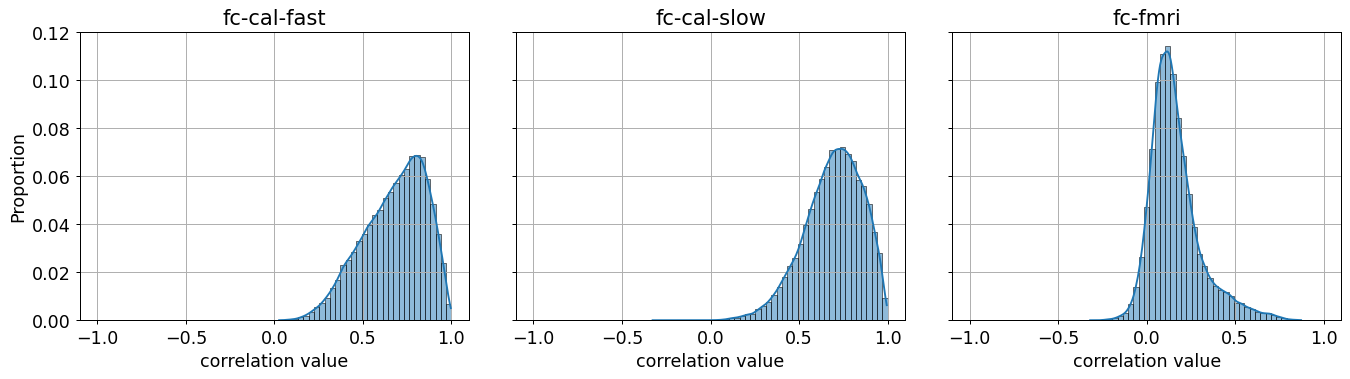

In [28]:
nrows = 1
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), dpi=90, sharey=True)
fig.tight_layout(h_pad=3)

for idx, col in enumerate(['fc-cal-fast', 'fc-cal-slow', 'fc-fmri']):
    corr_mats = main_df[col].to_list()
    tuv = lambda x: x[np.triu_indices_from(x, k=1)]
    corr_mats = np.concatenate(list(map(tuv, corr_mats)))
    
    ax = axs[idx]
    sns.histplot(corr_mats, stat='proportion', kde=True, ax=ax, binrange=[-1, 1], binwidth=0.03)
    ax.set(title=f'{col}', xlabel=f'correlation value')
    ax.grid(True)

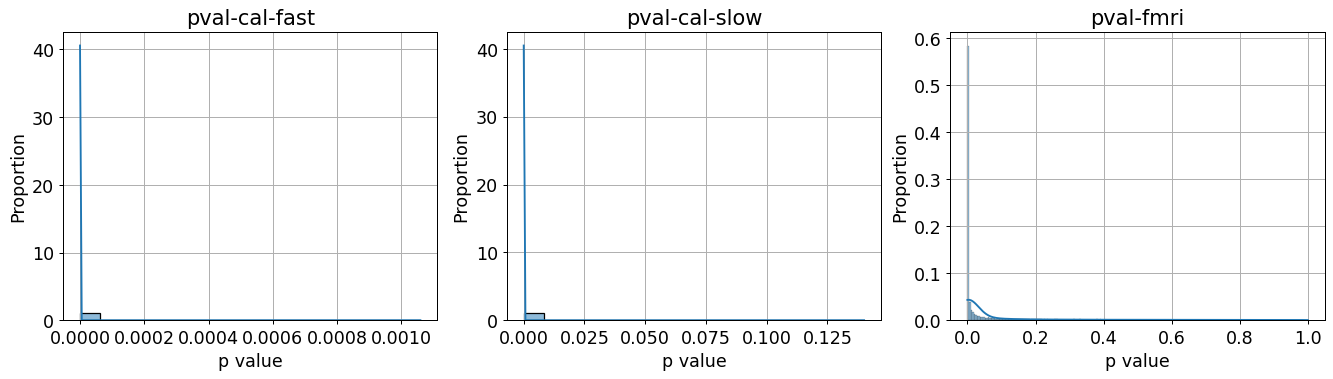

In [29]:
nrows = 1
ncols = 3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), dpi=90)
fig.tight_layout(h_pad=3)

for idx, col in enumerate(['pval-cal-fast', 'pval-cal-slow', 'pval-fmri']):
    corr_mats = main_df[col].to_list()
    tuv = lambda x: x[np.triu_indices_from(x, k=1)]
    corr_mats = np.concatenate(list(map(tuv, corr_mats)))
    if col == 'pval-fmri': corr_mats = corr_mats[corr_mats > 1e-10]
    ax = axs[idx]
    sns.histplot(corr_mats, stat='proportion', kde=True, ax=ax,)
    ax.set(title=f'{col}', xlabel=f'p value')
    ax.grid(True)